In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import datetime
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader
import sys 
sys.path.append("..") 
from model.dataset import *

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.filters import threshold_otsu, threshold_multiotsu
from sklearn.metrics import roc_auc_score
from scipy.stats import wilcoxon

得到掩码区域和最小外接矩形
最小外接矩形最小边不能小于25
SSIM刚好0.7
用PSNR代替MSE，值域不同MSE变化大，PSNR稳定
计算AUC
上下左右各加5像素才行
最后还是用老照片，没有用随机数

In [2]:
def calculate_min_bounding_rect(ROI_mask, method = 'add_each_side'):
    # 找到掩码中为1的点的坐标
    indices = np.column_stack(np.where(ROI_mask == 1))

    if len(indices) > 0:
        # 计算矩形的最小外界矩形
        min_x, min_y = np.min(indices, axis=0)
        max_x, max_y = np.max(indices, axis=0)
        if method == 'min_side':
            min_side_length = 30
            mid_x, mid_y = 0.5*(min_x+max_x), 0.5*(min_y+max_y)
            # 调整矩形，确保最短边不小于20
            rect_width = max(max_x - min_x, min_side_length)
            rect_height = max(max_y - min_y, min_side_length)
            bounding_rect = np.array([int(mid_x-0.5*rect_width), int(mid_x+0.5*rect_width), int(mid_y-0.5*rect_height), int(mid_y+0.5*rect_height)], dtype=np.uint8)
        if method == 'add_each_side': #用这个方法好
            add_pixels = 5
            bounding_rect = np.array([int(min_x-add_pixels), int(max_x+add_pixels), int(min_y-add_pixels), int(max_y+add_pixels)], dtype=np.uint8)
            # print("bounding_rect:", bounding_rect)
        
        return bounding_rect
    else:
        print("没有掩码")
        return None

# otsu法，分为四类，取亮度最大的一类作为阈值
def auc_img(fake_img, true_img, classes = 4): 
    # 0-255的256@256图片
    thresholds = threshold_multiotsu(true_img, classes=classes)
    binary = np.array(true_img >= thresholds[-1])
    return roc_auc_score(binary.flatten(), fake_img.flatten()/255)

# MSE的指标输入要求图像是-1~1
def renorm(img):
    return 2*(img/255)-1

def cal_metric(fake_img, target_img):
    #    fake_img, target_img = renorm(fake_img), renorm(target_img)
       AUC = auc_img(target_img, fake_img) 
       MSE = mse(renorm(target_img), renorm(fake_img)) #变成0-1
       SSIM = ssim(target_img, fake_img) #, data_range=1 
       PSNR = psnr(target_img, fake_img) #, data_range=1
    #    NRMSE = nrmse(target_img, fake_img) 
       return AUC, MSE, SSIM, PSNR

# 背景是最右边中间
def cal_ROI_background_and_metric(img, ROI_mask, bounding_rect=None, target_img=None, background_pix = 20):
    # print(img.shape, ROI_mask.shape)
    filter_rect_img = img[ROI_mask==1]
    ROI_mean, ROI_std = np.mean(filter_rect_img), np.std(filter_rect_img)
    backround_mean, background_std = np.mean(img[117:138,-20:]), np.std(img[117:138,-20:]) 
    if type(target_img) != np.ndarray:
        return ROI_mean, ROI_std, backround_mean, background_std
    else:
        rect_img = img[bounding_rect[0]:bounding_rect[1], bounding_rect[2]:bounding_rect[3]]
        rect_target_img = target_img[bounding_rect[0]:bounding_rect[1], bounding_rect[2]:bounding_rect[3]]
        return ROI_mean, ROI_std, backround_mean, background_std, *cal_metric(rect_img, rect_target_img)

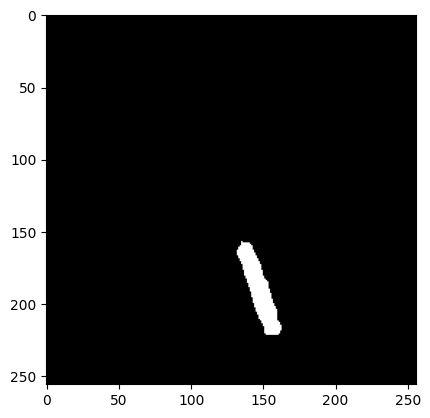

0.9722559713747848


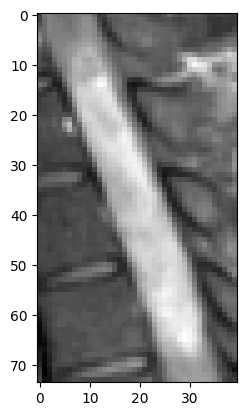

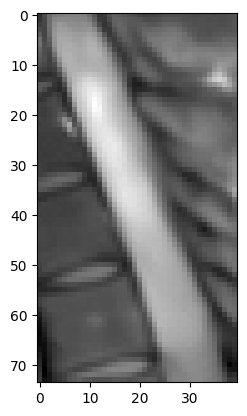

In [3]:
ROI_img = np.array(Image.open("./DiffusionSpinalMRISynthesis/results_output_pictures/1222_ROI/CT_1001190_ependymoma/CT_1001190_ependymoma_8.png"))[:,:256]
ground_truth_img = np.array(Image.open("./DiffusionSpinalMRISynthesis/results_output_pictures/1222_ROI/CT_1001190_ependymoma/CT_1001190_ependymoma_T1CE_pred_7.png"))[:,:256]
# 计算掩码和最小外接矩形
ROI_mask = np.where(ROI_img-ground_truth_img >0, 1, 0)
bounding_rect = calculate_min_bounding_rect(ROI_mask)
# indices = np.column_stack(np.where(ROI_mask == 1))
plt.imshow(ROI_mask, cmap='grey')
plt.show()
pred_img = np.array(Image.open("./DiffusionSpinalMRISynthesis/results_output_pictures/1222_ROI/CT_1001190_ependymoma/CT_1001190_ependymoma_T1CE_pred_7.png"))[:,256:]
rect_pred_img = pred_img[bounding_rect[0]:bounding_rect[1], bounding_rect[2]:bounding_rect[3]]
rect_target_img = ground_truth_img[bounding_rect[0]:bounding_rect[1], bounding_rect[2]:bounding_rect[3]]
auc_score = auc_img(rect_pred_img, rect_target_img)
print(auc_score)

plt.imshow(rect_target_img, cmap='grey')
plt.show()
plt.imshow(rect_pred_img, cmap='grey')
plt.show()
# plt.imshow(binary, cmap='grey')
# plt.show()

In [ ]:
def get_ROI_metrics():
    ROI_dir = "./DiffusionSpinalMRISynthesis/results_output_pictures/1222_ROI/"
    truth_dir = "./DiffusionSpinalMRISynthesis/results_output_pictures/Ground_True_imgs_test_spinal/"
    pix2pix_dir = "./DiffusionSpinalMRISynthesis/results_output_pictures/1228_pix2pix_500epoch_test_spinal/"
    # tanh的图像不好
    # diff_dir = "./DiffusionSpinalMRISynthesis/results_output_pictures/1230_diffusion_randomseed42_tanh_500epoch_test_spinal_16ddim/"

    patients_id = os.listdir(ROI_dir)
    df_truth_metrics =  pd.DataFrame({'ROI_mean':[], 'ROI_std':[], 'backround_mean':[], 'backround_std':[]})
    df_diff_metrics = pd.DataFrame({'ROI_mean':[], 'ROI_std':[], 'backround_mean':[], 'backround_std':[], 
                'ROI_rect_AUC':[], 'ROI_rect_MSE':[], 'ROI_rect_SSIM':[], 'ROI_rect_PSNR':[]})
    df_pix2pix_metrics = pd.DataFrame({'ROI_mean':[], 'ROI_std':[], 'backround_mean':[], 'backround_std':[], 
                'ROI_rect_AUC':[], 'ROI_rect_MSE':[], 'ROI_rect_SSIM':[], 'ROI_rect_PSNR':[]})
    for patient in tqdm(patients_id):
        print('patient:', patient)
        patient_path = os.path.join(ROI_dir, patient)
        ROI_img_name = [path for path in os.listdir(patient_path) if len(path.split('_'))==4][0]
        pred_img_name = [path for path in os.listdir(patient_path) if len(path.split('_'))==6][0]
        layer = pred_img_name.split('_')[-1].split('.')[0]
        ROI_img = np.array(Image.open(os.path.join(patient_path, ROI_img_name)))[:,:256]
        ground_truth_img = np.array(Image.open(os.path.join(patient_path, pred_img_name)))[:,:256]
        # 计算掩码和最小外接矩形
        ROI_mask = np.where(ROI_img-ground_truth_img >0, 1, 0)
        bounding_rect = calculate_min_bounding_rect(ROI_mask)

        ground_truth_img = np.array(Image.open(os.path.join(os.path.join(truth_dir, patient), patient+'_T1CE_groundTrue_'+layer+'.png')))[:,:256]
        diff_img = np.array(Image.open(os.path.join(patient_path, pred_img_name)))[:, 256:]
        # diff_img = np.array(Image.open(os.path.join(os.path.join(diff_dir, patient), pred_img_name)))
        pix2pix_img = np.array(Image.open(os.path.join(os.path.join(pix2pix_dir, patient), pred_img_name)))

        df_truth_metrics.loc[df_truth_metrics.shape[0],:] = [*cal_ROI_background_and_metric(ground_truth_img, ROI_mask)]
        df_diff_metrics.loc[df_diff_metrics.shape[0],:] = [*cal_ROI_background_and_metric(diff_img, ROI_mask, bounding_rect, ground_truth_img)]
        df_pix2pix_metrics.loc[df_pix2pix_metrics.shape[0],:] = [*cal_ROI_background_and_metric(pix2pix_img, ROI_mask, bounding_rect, ground_truth_img)]

    df_truth_metrics.insert(0, 'patient_id', patients_id)
    df_diff_metrics.insert(0, 'patient_id', patients_id)
    df_pix2pix_metrics.insert(0, 'patient_id', patients_id)
    # 有问题
    # df_truth_metrics['ROI_SNR'] = df_truth_metrics['ROI_mean']/(df_truth_metrics['backround_std']+1)
    # df_diff_metrics['ROI_SNR'] = df_diff_metrics['ROI_mean']/(df_diff_metrics['backround_std']+1)
    # df_pix2pix_metrics['ROI_SNR'] = df_pix2pix_metrics['ROI_mean']/(df_pix2pix_metrics['backround_std']+1)

    return df_truth_metrics, df_diff_metrics, df_pix2pix_metrics

df_truth_metrics, df_diff_metrics, df_pix2pix_metrics = get_ROI_metrics()

In [12]:
# 保存csv文件
df_truth_metrics.to_csv("./DiffusionSpinalMRISynthesis/Test_models/metrics/ROI_ground_truth_metrics_1231.csv")
df_diff_metrics.to_csv("./DiffusionSpinalMRISynthesis/Test_models/metrics/ROI_diff_pred_metrics_1231.csv")
df_pix2pix_metrics.to_csv("./DiffusionSpinalMRISynthesis/Test_models/metrics/ROI_pix2pix_pred_metrics_1231.csv")

In [13]:
# 保存各项的均值
# 病变区域最小外接矩形的SSIM PSNR AUC MSE NRMSE的均值和方差
# 对于diff和pix2pix
df_diff_sum = df_diff_metrics[['ROI_rect_AUC', 'ROI_rect_MSE', 'ROI_rect_SSIM', 'ROI_rect_PSNR']]
df_diff_sum = pd.concat([df_diff_sum.mean(axis=0), df_diff_sum.std(axis=0)], axis=1).rename(columns={0:'diff_mean', 1:'diff_std'})
df_pix2pix_sum = df_pix2pix_metrics[['ROI_rect_AUC', 'ROI_rect_MSE', 'ROI_rect_SSIM', 'ROI_rect_PSNR']]
df_pix2pix_sum = pd.concat([df_pix2pix_sum.mean(axis=0), df_pix2pix_sum.std(axis=0)], axis=1).rename(columns={0:'pix2pix_mean', 1:'pix2pix_std'})

df_diff_sum.to_csv("./DiffusionSpinalMRISynthesis/Test_models/metrics/ROI_diff_sum_result_1231.csv")
df_pix2pix_sum.to_csv("./DiffusionSpinalMRISynthesis/Test_models/metrics/ROI_pix2pix_sum_result_1231.csv")

In [5]:
df_truth_metrics.iloc[:,1:].mean(axis=0)

ROI_mean          119.379677
ROI_std            36.647994
backround_mean      1.464237
backround_std       0.912920
dtype: float64

In [13]:
df_diff_metrics.iloc[:,1:].mean(axis=0)

ROI_mean          127.397606
ROI_std            38.502162
backround_mean      2.629492
backround_std       1.594099
ROI_rect_AUC        0.942627
ROI_rect_MSE        0.038490
ROI_rect_SSIM       0.716417
ROI_rect_PSNR      21.197603
dtype: float64

In [7]:
df_pix2pix_metrics.iloc[:,1:].mean(axis=0)

ROI_mean          111.790998
ROI_std            32.293118
backround_mean      0.661009
backround_std       0.922590
ROI_rect_AUC        0.866164
ROI_rect_MSE        0.059368
ROI_rect_SSIM       0.552505
ROI_rect_PSNR      19.240086
dtype: float64

In [14]:
df_diff_metrics

,patient_id,ROI_mean,ROI_std,backround_mean,backround_std,ROI_rect_MSE,ROI_rect_SSIM,ROI_rect_PSNR,ROI_rect_NRMSE,ROI_SNR
0,CT_1001190_ependymoma,133.914530,32.473113,1.633333,0.997059,424.383333,0.730184,21.853220,0.176607,67.055865
1,CT_2247423_osteosarcoma,156.590426,47.040404,2.319048,1.194479,478.530000,0.739978,21.331712,0.182462,71.356539
2,CT_2268863_GCTB,97.139216,32.597940,1.692857,0.874750,268.054545,0.740538,23.848572,0.192554,51.814498
3,CT_2633513_UPsarcoma,102.755079,22.485959,1.278571,1.042441,311.372093,0.640387,23.198007,0.171481,50.309932
4,CT_2748560_EG,125.132921,44.319805,1.869048,1.424110,328.090030,0.803356,22.970873,0.161728,51.620148
...,...,...,...,...,...,...,...,...,...,...
189,T_3722936_M,125.451128,45.310203,1.711905,0.933683,960.963200,0.654025,18.303736,0.243014,64.876797
190,T_3726787_schwannoma,118.115016,42.970748,1.769048,1.300730,470.560000,0.848923,21.404654,0.193032,51.338056
191,T_3744881_M,117.083333,6.550551,2.545238,1.497729,193.840000,0.881631,25.256370,0.174538,46.875919
192,T_3781492_schwannoma,142.965909,49.607959,1.550000,1.374903,1000.478400,0.733084,18.128726,0.292902,60.198641


In [14]:
df_musle = pd.read_csv("./DiffusionSpinalMRISynthesis/Test_models/metrics/ROI_MUSLES.csv")
df_musle['patient_id']= df_musle['patient_id'].apply(lambda x: x.split('_')[0]+'_'+x.split('_')[1]+'_'+x.split('_')[2])
df_musle

,patient_id,ground_truth_muscle_mean,ground_truth_muscle_std,pred_muscle_mean,pred_muscle_std
0,C_1218258_M,138.667,4.183,128.364,4.105
1,C_1569819_GCTB,110.538,4.052,121.115,1.633
2,C_1573048_chordoma,107.176,4.086,113.935,4.618
3,C_1648750_GCTB,101.406,2.638,100.235,1.860
4,C_1873836_chordoma,112.308,6.329,112.351,2.831
...,...,...,...,...,...
188,TL_3451980_schwannoma,53.979,3.207,98.327,5.490
189,TL_3549776_schwannoma,130.139,7.276,144.570,4.837
190,TL_3646402_schwannoma,76.946,4.870,64.000,2.623
191,TL_3718635_M,65.717,4.913,79.222,3.323


In [15]:
df_truth_mucle_merge = pd.merge(df_truth_metrics, df_musle, on='patient_id')
df_truth_mucle_merge['CNR'] = (df_truth_mucle_merge['ROI_mean']-df_truth_mucle_merge['ground_truth_muscle_mean'])/df_truth_mucle_merge['ground_truth_muscle_std']
df_truth_mucle_merge['SIR'] = df_truth_mucle_merge['ROI_mean']/df_truth_mucle_merge['ground_truth_muscle_mean']
df_truth_mucle_merge['SNR'] = df_truth_mucle_merge['ROI_mean']/df_truth_mucle_merge['ground_truth_muscle_std']
df_truth_mucle_merge

,patient_id,ROI_mean,ROI_std,backround_mean,backround_std,ground_truth_muscle_mean,ground_truth_muscle_std,pred_muscle_mean,pred_muscle_std,CNR,SIR,SNR
0,CT_1001190_ependymoma,146.610501,37.302884,2.150000,0.872258,132.622,4.585,128.686,5.648,3.050927,1.105476,31.976118
1,CT_2247423_osteosarcoma,141.915653,41.292452,1.361905,0.800283,117.222,5.221,128.812,5.219,4.729679,1.210657,27.181700
2,CT_2268863_GCTB,91.437255,25.094781,1.302381,0.911040,79.417,4.228,91.091,3.741,2.843012,1.151356,21.626598
3,CT_2633513_UPsarcoma,112.890519,28.279211,1.142857,0.770635,134.000,3.834,155.714,2.533,-5.505864,0.842467,29.444580
4,CT_2748560_EG,116.678516,38.038562,0.988095,0.751095,118.938,5.000,124.250,2.866,-0.451897,0.981003,23.335703
...,...,...,...,...,...,...,...,...,...,...,...,...
188,T_3722936_M,134.988722,53.500297,0.000000,0.000000,66.047,3.057,80.471,2.858,22.552084,2.043828,44.157253
189,T_3726787_schwannoma,122.948882,57.941283,0.659524,0.724260,122.663,10.318,137.458,8.530,0.027707,1.002331,11.915961
190,T_3744881_M,135.566667,27.861782,0.559524,0.699510,123.869,11.971,113.143,5.719,0.977167,1.094436,11.324590
191,T_3781492_schwannoma,121.106061,40.213683,0.528571,0.590918,67.100,5.930,71.871,6.400,9.107261,1.804859,20.422607


In [16]:
df_diff_mucle_merge = pd.merge(df_diff_metrics, df_musle, on='patient_id')
df_diff_mucle_merge['CNR'] = (df_diff_mucle_merge['ROI_mean']-df_diff_mucle_merge['ground_truth_muscle_mean'])/df_diff_mucle_merge['pred_muscle_std']
df_diff_mucle_merge['SIR'] = df_diff_mucle_merge['ROI_mean']/df_diff_mucle_merge['pred_muscle_mean']
df_diff_mucle_merge['SNR'] = df_diff_mucle_merge['ROI_mean']/df_diff_mucle_merge['pred_muscle_std']
df_diff_mucle_merge

,patient_id,ROI_mean,ROI_std,backround_mean,backround_std,ROI_rect_AUC,ROI_rect_MSE,ROI_rect_SSIM,ROI_rect_PSNR,ground_truth_muscle_mean,ground_truth_muscle_std,pred_muscle_mean,pred_muscle_std,CNR,SIR,SNR
0,CT_1001190_ependymoma,133.914530,32.473113,1.633333,0.997059,0.980824,0.021495,0.731935,22.697218,132.622,4.585,128.686,5.648,0.228847,1.040630,23.710080
1,CT_2247423_osteosarcoma,156.590426,47.040404,2.319048,1.194479,0.986905,0.024632,0.768241,22.105635,117.222,5.221,128.812,5.219,7.543289,1.215651,30.003914
2,CT_2268863_GCTB,97.139216,32.597940,1.692857,0.874750,0.976721,0.012526,0.767450,25.042324,79.417,4.228,91.091,3.741,4.737294,1.066398,25.966110
3,CT_2633513_UPsarcoma,102.755079,22.485959,1.278571,1.042441,0.900564,0.014784,0.714772,24.322614,134.000,3.834,155.714,2.533,-12.335144,0.659896,40.566553
4,CT_2748560_EG,125.132921,44.319805,1.869048,1.424110,0.984244,0.018788,0.781793,23.281779,118.938,5.000,124.250,2.866,2.161522,1.007106,43.661173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,T_3722936_M,125.451128,45.310203,1.711905,0.933683,0.905859,0.055657,0.651381,18.565399,66.047,3.057,80.471,2.858,20.785209,1.558961,43.894726
189,T_3726787_schwannoma,118.115016,42.970748,1.769048,1.300730,0.972680,0.026619,0.832833,21.768604,122.663,10.318,137.458,8.530,-0.533175,0.859281,13.847012
190,T_3744881_M,117.083333,6.550551,2.545238,1.497729,0.990683,0.017066,0.830057,23.699374,123.869,11.971,113.143,5.719,-1.186513,1.034826,20.472693
191,T_3781492_schwannoma,142.965909,49.607959,1.550000,1.374903,0.886300,0.056724,0.708339,18.482907,67.100,5.930,71.871,6.400,11.854048,1.989202,22.338423


In [17]:
df_truth_mucle_merge.to_csv("./DiffusionSpinalMRISynthesis/Test_models/metrics/df_truth_muscle_merge_1231.csv")
df_diff_mucle_merge.to_csv("./DiffusionSpinalMRISynthesis/Test_models/metrics/df_diff_muscle_merge_1231.csv")

In [17]:
def cal_stat(df1, df2, keys):
    res_df = pd.DataFrame({'df1_mean':[], 'df1_std':[], 'df2_mean':[], 'df2_std':[], 'p_value':[]})
    for key in keys:
        print(np.mean(df1[key]), np.std(df1[key]))
        print(np.mean(df2[key]), np.std(df2[key]))
        stat, p_value = wilcoxon(x=df1[key], y=df2[key])
        print(f"stat: {stat}, p_value: {p_value}")
        res_df.loc[res_df.shape[0], :] = [np.mean(df1[key]), np.std(df1[key]), np.mean(df2[key]), np.std(df2[key]), p_value]
    res_df['key'] = keys
    
    return res_df

res_df = cal_stat(df_truth_mucle_merge, df_diff_mucle_merge, ['SNR', 'CNR', 'SIR'])
res_df =res_df.rename(columns={'df1_mean':'truthimg_mean', 'df1_std':'truthimg_std', 'df2_mean':'diffimg_mean', 'df2_std':'diffimg_std'})
res_df.to_csv('./DiffusionSpinalMRISynthesis/Test_models/metrics/CNR_SNR_SIR_diff_truth_1231.csv')

30.60730697814923 21.943161200648962
29.98115285361739 17.206560863538154
stat: 8916.0, p_value: 0.5672806108450081
5.395499421434448 11.882179063779919
5.808798021946386 9.19318948024784
stat: 6919.0, p_value: 0.0016771029338218538
1.2049564340076933 0.36512961795504584
1.175488610543852 0.33887845570128494
stat: 7923.0, p_value: 0.06430940921431387
